# `Notebook Contents`
<li>Importing The Libraries</li>
<li>Reading The Data</li>
<li>Data Inspection</li>
<li>Exploratory Data Analysis (EDA)</li>
<li>Data Preprocessing</li>
<li>Building The Models</li>
<li>Hyperparameter Tuning</li>
<li>Pipeline</li>
<li>Testing Stage</li>

### `Importing The Libraries`

In [254]:
#Main libraries
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from statistics import mean
import warnings
warnings.filterwarnings('ignore')
sns.set(rc = {'figure.figsize':[7,7]},font_scale = 1)

#Preprocessing
from datasist.structdata import detect_outliers
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import OneHotEncoder

#Algorithms
from sklearn.linear_model import LinearRegression
from sklearn.linear_model import Ridge
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor
from xgboost import XGBRegressor

#Tuning
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import RandomizedSearchCV

#Metrics
from sklearn.metrics import r2_score
from sklearn.metrics import mean_squared_error
from sklearn.metrics import mean_absolute_error

#Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.compose import make_column_transformer
from sklearn.pipeline import make_pipeline
from sklearn.pipeline import Pipeline

### `Reading The Data`

In [2]:
df = pd.read_excel('Data_Train.xlsx')

### `Data Inspection`

In [3]:
#The first five rows
df.head()

,Airline,Date_of_Journey,Source,Destination,Route,Dep_Time,Arrival_Time,Duration,Total_Stops,Additional_Info,Price
0,IndiGo,24/03/2019,Banglore,New Delhi,BLR → DEL,22:20,01:10 22 Mar,2h 50m,non-stop,No info,3897
1,Air India,1/05/2019,Kolkata,Banglore,CCU → IXR → BBI → BLR,05:50,13:15,7h 25m,2 stops,No info,7662
2,Jet Airways,9/06/2019,Delhi,Cochin,DEL → LKO → BOM → COK,09:25,04:25 10 Jun,19h,2 stops,No info,13882
3,IndiGo,12/05/2019,Kolkata,Banglore,CCU → NAG → BLR,18:05,23:30,5h 25m,1 stop,No info,6218
4,IndiGo,01/03/2019,Banglore,New Delhi,BLR → NAG → DEL,16:50,21:35,4h 45m,1 stop,No info,13302


In [4]:
#The data shape
df.shape

(10683, 11)

In [5]:
#Data information
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10683 entries, 0 to 10682
Data columns (total 11 columns):
 #   Column           Non-Null Count  Dtype 
---  ------           --------------  ----- 
 0   Airline          10683 non-null  object
 1   Date_of_Journey  10683 non-null  object
 2   Source           10683 non-null  object
 3   Destination      10683 non-null  object
 4   Route            10682 non-null  object
 5   Dep_Time         10683 non-null  object
 6   Arrival_Time     10683 non-null  object
 7   Duration         10683 non-null  object
 8   Total_Stops      10682 non-null  object
 9   Additional_Info  10683 non-null  object
 10  Price            10683 non-null  int64 
dtypes: int64(1), object(10)
memory usage: 918.2+ KB


- There is a missing value in `Route` and `Total_Stops`.
- We have only one numerical column in the data and the other columns are categorical.

In [6]:
#Data description
df.describe()

,Price
count,10683.000000
mean,9087.064121
std,4611.359167
min,1759.000000
25%,5277.000000
50%,8372.000000
75%,12373.000000
max,79512.000000


- The mean not larger a lot than the median so we can say the label looks like normal distribution.
- The label has a high variance.

### `Exploratory Data Analysis (EDA)`

In [7]:
#Converting the date from object type to datetime type
df['Date_of_Journey'] = pd.to_datetime(df['Date_of_Journey'],format='%d/%m/%Y')

#Appending month, day and weekday to the dataset
df['Month'] = df['Date_of_Journey'].dt.month
df['WeekDay'] = df['Date_of_Journey'].dt.day_name()
df['Day'] = df['Date_of_Journey'].dt.day

#Adding seasons feature
def check_season(month):
    '''
    This function for checking the seasons based on the month.
    INPUT:
    month: int. The month number.
    OUTPUT:
    The season.
    '''
    if month == 1 or month == 2:
        return 'Winter'
    elif month == 3 or month == 4:
        return 'Spring'
    elif month == 5 or month == 6:
        return 'Summer'
    elif month == 7 or month == 8:
        return 'Monsoon'
    elif month == 9 or month == 10:
        return 'Autumn'
    else:
        return 'Pre Winter'
df['Season'] = df['Month'].apply(lambda month: check_season(month))

#Appending weekend column
df['Weekend'] = df['WeekDay'].apply(lambda day: 1 if day == 'Sunday' else 0)

#Converting the duration to seconds
def convert_dur(duration):
    '''
    This function for converting the duration from hours and minutes to seconds.
    INPUT:
    duration: str. The duration in hours and minutes.
    OUTPUT:
    The duration in seconds.
    '''
    try:
        hr_to_sec = int(duration.split(' ')[0].replace('h',''))* 60 * 60
    except:
        hr_to_sec = 0
    try:
        min_to_sec = int(duration.split(' ')[1].replace('m','')) * 60
    except:
        min_to_sec = 0
    return hr_to_sec + min_to_sec
df['Duration'] = df['Duration'].apply(lambda dur:convert_dur(dur))

In [8]:
df.head()

,Airline,Date_of_Journey,Source,Destination,Route,Dep_Time,Arrival_Time,Duration,Total_Stops,Additional_Info,Price,Month,WeekDay,Day,Season,Weekend
0,IndiGo,2019-03-24,Banglore,New Delhi,BLR → DEL,22:20,01:10 22 Mar,10200,non-stop,No info,3897,3,Sunday,24,Spring,1
1,Air India,2019-05-01,Kolkata,Banglore,CCU → IXR → BBI → BLR,05:50,13:15,26700,2 stops,No info,7662,5,Wednesday,1,Summer,0
2,Jet Airways,2019-06-09,Delhi,Cochin,DEL → LKO → BOM → COK,09:25,04:25 10 Jun,68400,2 stops,No info,13882,6,Sunday,9,Summer,1
3,IndiGo,2019-05-12,Kolkata,Banglore,CCU → NAG → BLR,18:05,23:30,19500,1 stop,No info,6218,5,Sunday,12,Summer,1
4,IndiGo,2019-03-01,Banglore,New Delhi,BLR → NAG → DEL,16:50,21:35,17100,1 stop,No info,13302,3,Friday,1,Spring,0


In [9]:
#Required functions for visualization

def countplot(data,x,palette,title,fsize = None,y = None,hue = None):
    '''
    This function for showing the counts of observations in each categorical value.
    INPUT:
    data: pandas.core.frame.DataFrame. The dataset.
    x: str. Feature name in the dataset.
    y: str. Feature name in the dataset.
    palette: str. Palette name.
    title: str. Countplot title.
    fsize: tuple. The figure size.
    hue: str. Feature name in the dataset.
    OUTPUT:
    Countplot represent the counts of observations in each categorical value.
    '''
    plt.figure(figsize = fsize)
    sns.countplot(data=data,x=x,y=y,hue=hue,palette=palette)
    plt.xlabel(x.title(),color = 'red',size = 15)
    plt.xticks(rotation = 25)
    plt.ylabel("Count",color = 'red',size = 15)
    plt.title(title.title(),color = 'red',size = 15)
    if hue != None:
        plt.legend(title=hue.title())
    plt.show()

def barplot(data,x,y,palette,title,fsize = None,hue = None,estimator = mean):
    '''
    This function for plotting the barplot.
    INPUT:
    data: pandas.core.frame.DataFrame. The dataset.
    x: str. Feature name in the dataset.
    y: str. Feature name in the dataset.
    palette: str. Palette name.
    title: str. Countplot title.
    fsize: tuple. The figure size.
    hue: str. Feature name in the dataset.
    estimator: function. Statistical function to estimate within each categorical bin.
    OUTPUT:
    Barplot shape.
    '''
    plt.figure(figsize = fsize)
    sns.barplot(data=data,x=x,y=y,palette=palette,hue=hue,estimator=estimator)
    plt.xlabel(x.title(),color = 'red',size = 15)
    plt.xticks(rotation = 25)
    plt.ylabel(y.title(),color = 'red',size = 15)
    plt.title(title.title(),color = 'red',size = 15)
    if hue != None:
        plt.legend(title=hue.title())
    plt.show()

def scatterplot(data,x,y,title):
    '''
    This function plots the correlation between two columns of the data.
    INPUT:
    data: pandas.core.frame.DataFrame. The dataset.
    x: pandas.core.series.Series. A column in the dataset.
    y: pandas.core.series.Series. Another column name in the dataset.
    title: str. Scatterplot title.
    OUTPUT:
    Scatterplot shows the correlation between two columns of the data.
    '''
    sns.scatterplot(data=data,x=x,y=y)
    plt.xlabel(x.title(),color='red',size=15)
    plt.ylabel(y.title(),color='red',size=15)
    plt.title(title.title(),color='red',size=15)
    plt.show()

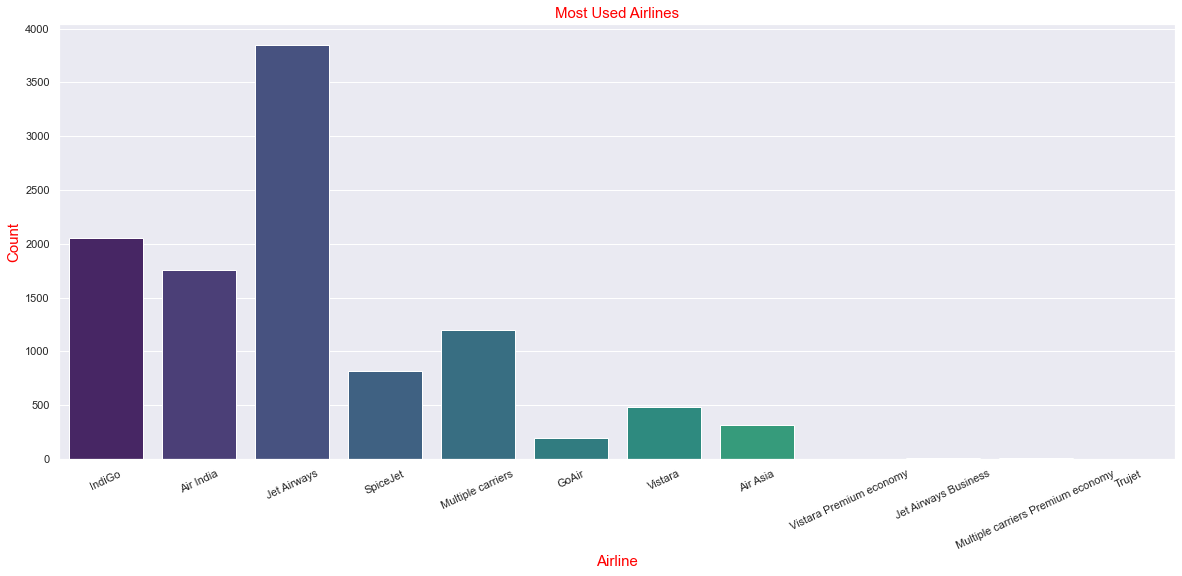

In [10]:
countplot(df,'Airline','viridis','Most used airlines',(20,8))

- Most used airline is `Jet Airways`, and less used airlines are `Multiple carriers Premium economy`, `Jet Airways Business`, `Vistara Premium economy`, and `Trujet`.                    

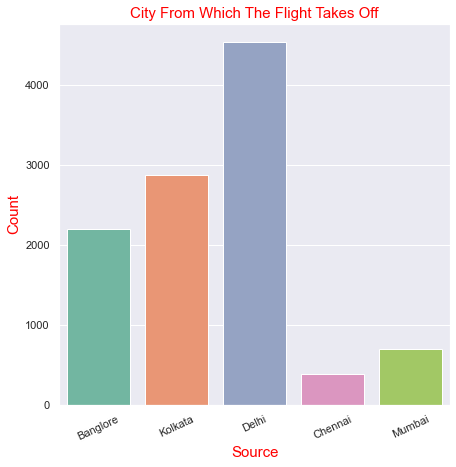

In [11]:
countplot(df,'Source','Set2','City from which the flight takes off')

- Most flights start from `Delhi`.

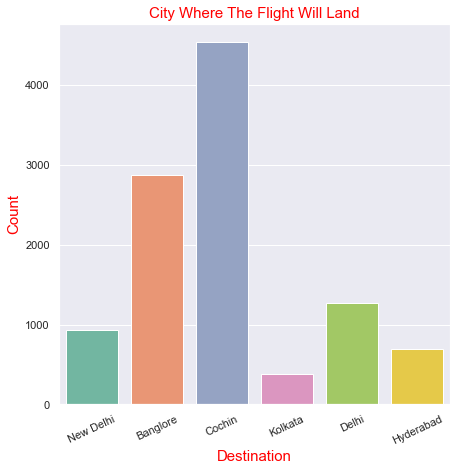

In [12]:
countplot(df,'Destination','Set2','City where the flight will land')

- Most flights land on `Cochin`.

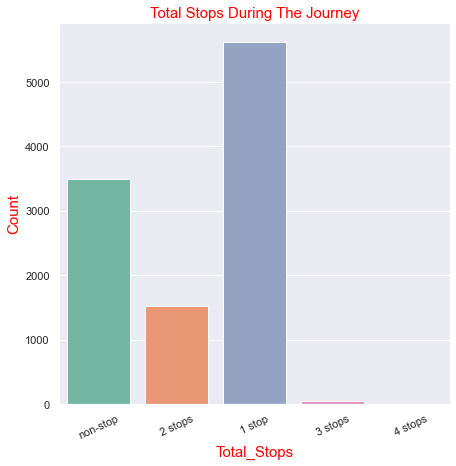

In [13]:
countplot(df,'Total_Stops','Set2','Total stops during the journey')

- Most of the flights stopped once.

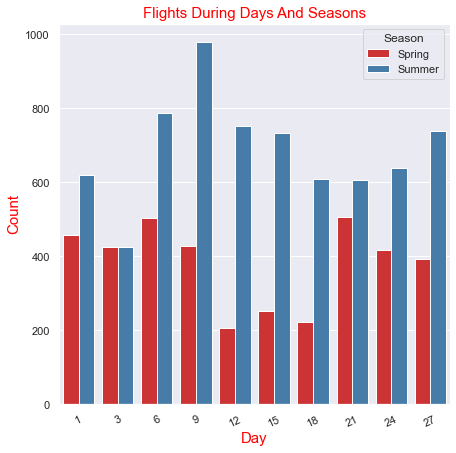

In [14]:
countplot(df,'Day','Set1','Flights during days and seasons',hue = 'Season')

- Airlines work ten days per month in two seasons Spring and Summer.
- Airlines work more on Summer than on Spring.

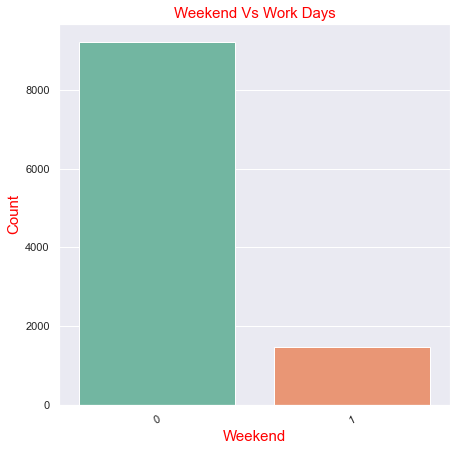

In [15]:
countplot(df,'Weekend','Set2','Weekend VS Work days')

- It seems that the passengers are traveling during the work days more than weekend.

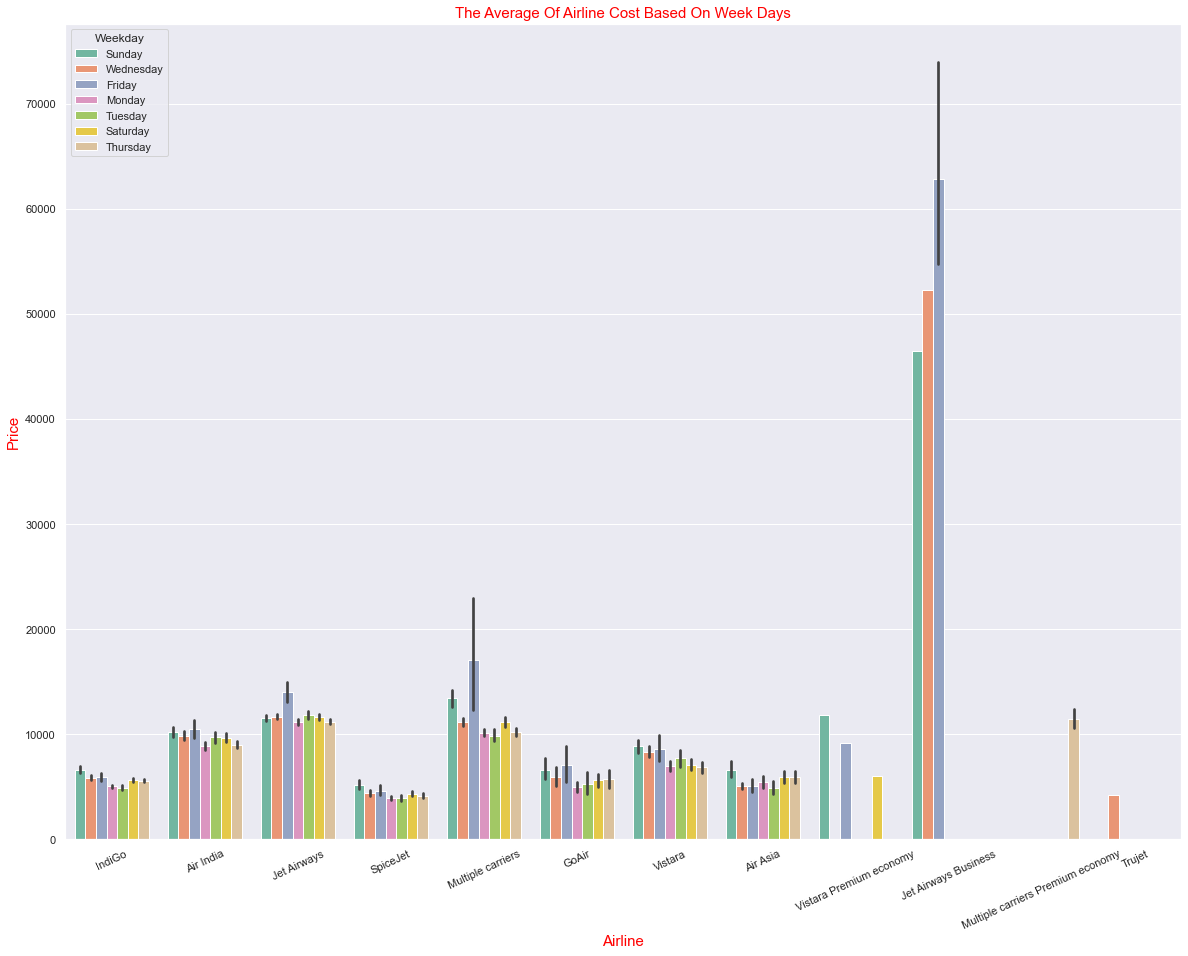

In [16]:
barplot(df,'Airline','Price','Set2','The average of airline cost based on week days',(20,15),'WeekDay')

- `Jet Airways Business` works three days per week and it's the most expensive one.

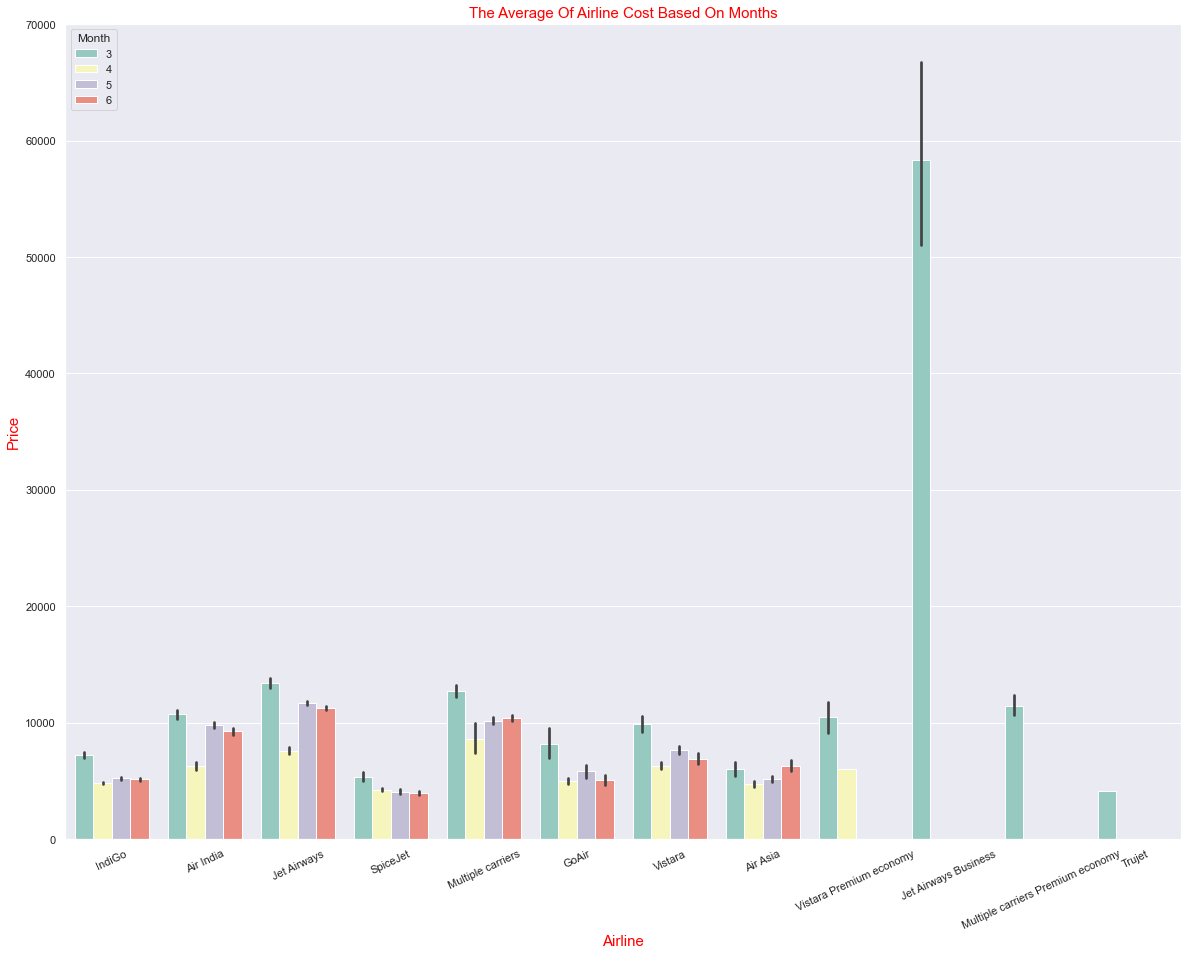

In [17]:
barplot(df,'Airline','Price','Set3','The average of airline cost based on months',(20,15),'Month')

- It seems that the cost on `March` is very expensive.
- `Jet Airways Business` works only on march and it's the most expensive airline on march.

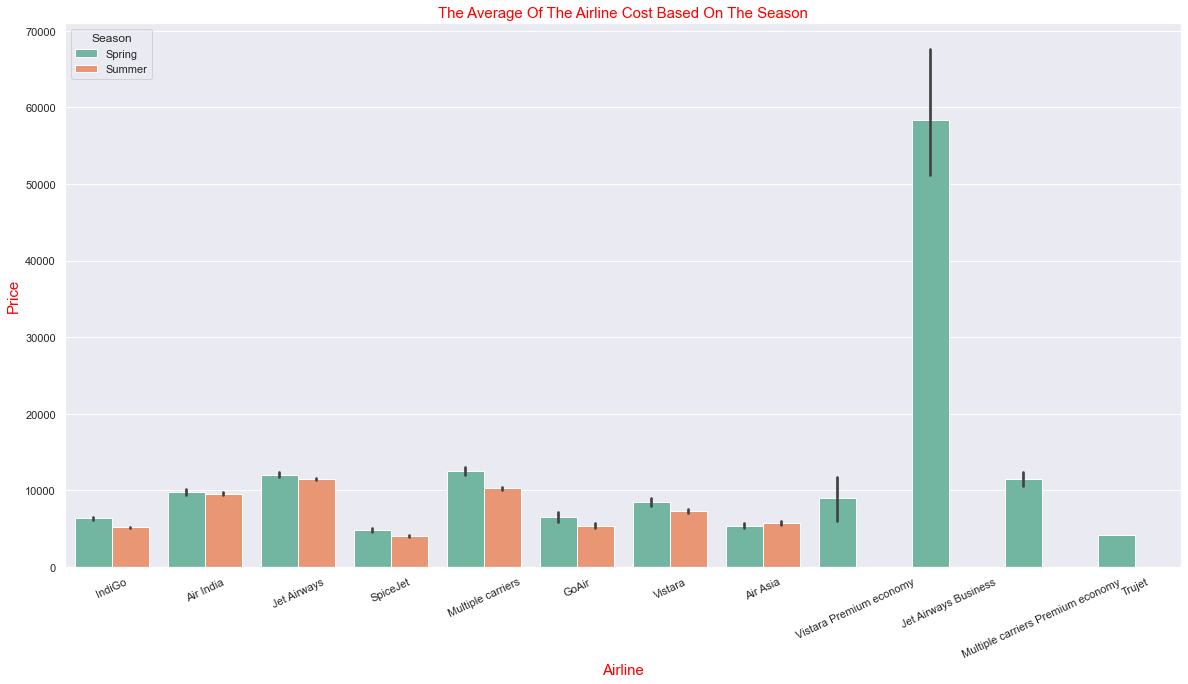

In [18]:
barplot(df,'Airline','Price','Set2','The average of the airline cost based on the season',(20,10),'Season')

- The cost on the Spring highest than on the Summer, beside there are some airlines don't work on the summer.

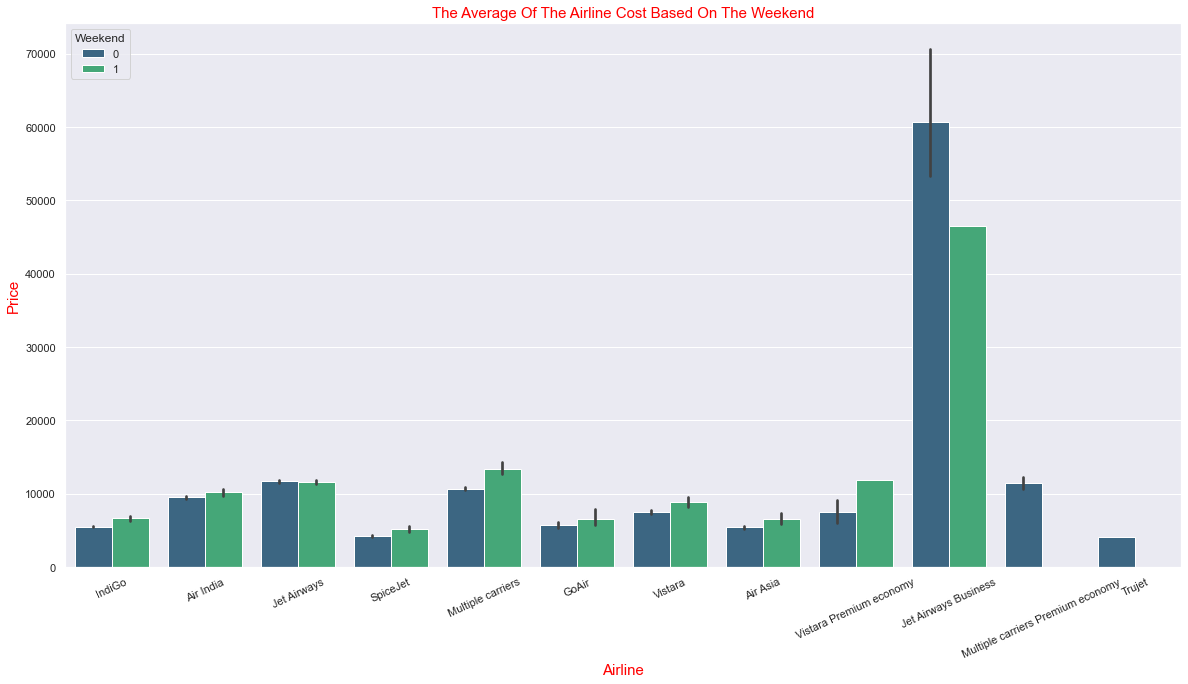

In [19]:
barplot(df,'Airline','Price','viridis','The average of the airline cost based on the weekend',(20,10),'Weekend')

- Most airlines make the cost higher during weekend than work days.

In [20]:
#The unique values
df['Additional_Info'].unique()

array(['No info', 'In-flight meal not included',
       'No check-in baggage included', '1 Short layover', 'No Info',
       '1 Long layover', 'Change airports', 'Business class',
       'Red-eye flight', '2 Long layover'], dtype=object)

- `No info` and `No Info` are the same.

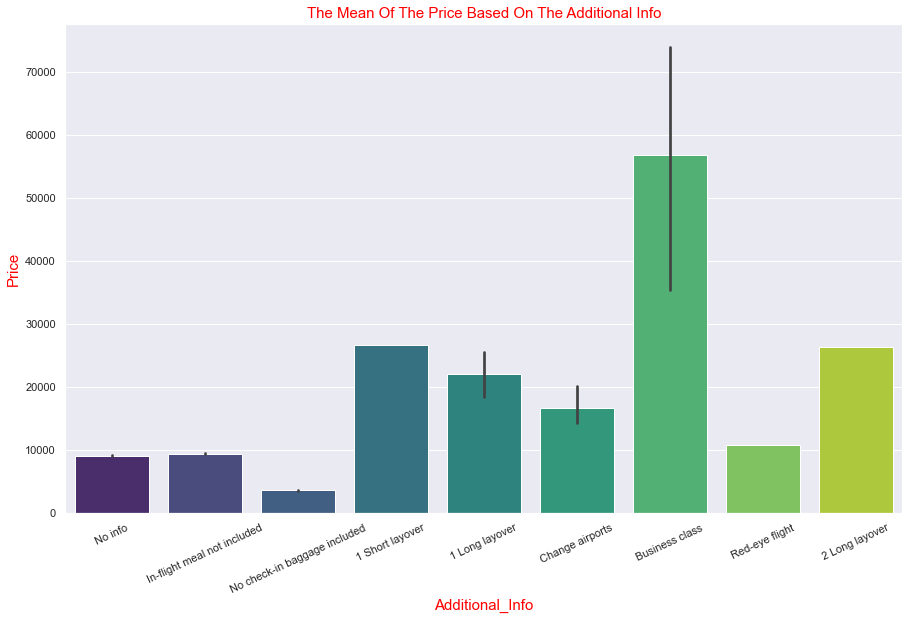

In [21]:
#Unified No info value
df['Additional_Info'].replace({'No Info':'No info'},inplace = True)

#The mean of the price for each case
barplot(df,'Additional_Info','Price','viridis','The mean of the price based on the additional info',(15,9))

- The price for `Business class` flights in average is almost equal to 57000 Indian rupee and it's the highest cost compared to the others.

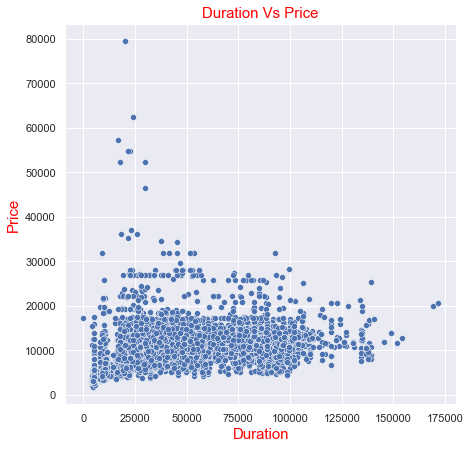

In [79]:
scatterplot(df,'Duration','Price','Duration vs price')

- It seems that the correlation between the `duration` and the `price` is `weak positive correlation` and also there are some outliers.

### `Data Preprocessing`

In [87]:
#Taking a copy from the data
df_new = df.copy()

In [88]:
df_new.head()

,Airline,Date_of_Journey,Source,Destination,Route,Dep_Time,Arrival_Time,Duration,Total_Stops,Additional_Info,Price,Month,WeekDay,Day,Season,Weekend
0,IndiGo,2019-03-24,Banglore,New Delhi,BLR → DEL,22:20,01:10 22 Mar,10200,non-stop,No info,3897,3,Sunday,24,Spring,1
1,Air India,2019-05-01,Kolkata,Banglore,CCU → IXR → BBI → BLR,05:50,13:15,26700,2 stops,No info,7662,5,Wednesday,1,Summer,0
2,Jet Airways,2019-06-09,Delhi,Cochin,DEL → LKO → BOM → COK,09:25,04:25 10 Jun,68400,2 stops,No info,13882,6,Sunday,9,Summer,1
3,IndiGo,2019-05-12,Kolkata,Banglore,CCU → NAG → BLR,18:05,23:30,19500,1 stop,No info,6218,5,Sunday,12,Summer,1
4,IndiGo,2019-03-01,Banglore,New Delhi,BLR → NAG → DEL,16:50,21:35,17100,1 stop,No info,13302,3,Friday,1,Spring,0


In [91]:
#Removing the outliers
outliers_indices = detect_outliers(df_new,0,['Price'])
df_new.drop(outliers_indices,inplace = True)
len(outliers_indices)

0

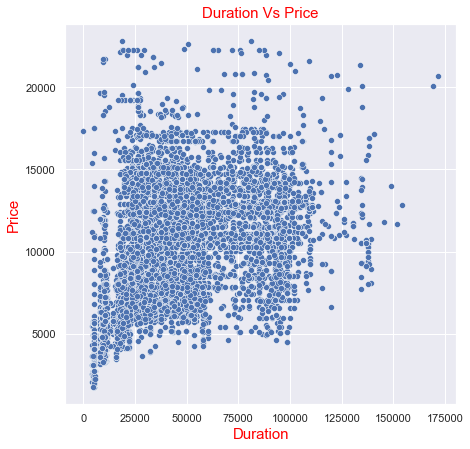

In [92]:
scatterplot(df_new,'Duration','Price','Duration vs price')

- It seems better than the previous one when there was an outliers.

In [93]:
#Removing the missing value
df_new['Total_Stops'].fillna(df_new['Total_Stops'].mode()[0],inplace = True)

#Splitting the data to x and y
x = df_new.drop(['Date_of_Journey','Route','Dep_Time', 'Arrival_Time','Price'],axis = 1)
y = df_new['Price']

#Getting the dummies
x = pd.get_dummies(x,drop_first=True)

#The shape of x and y
print('X Shape:',x.shape)
print('Y Shape:',y.shape)

#Applying standard scaler
scaler = StandardScaler()
scaler.fit(x)
x_new = scaler.transform(x)

#Splitting the data for training and testing
x_train,x_test,y_train,y_test = train_test_split(x_new,y,test_size=0.2,random_state=0,shuffle = False)

X Shape: (10587, 39)
Y Shape: (10587,)


### `Building The Models`

In [94]:
def performance(model,x_train,y_train,y_pred,y_test):
    '''
    This function for calculating the performance of the model.
    INPUT:
    model: Regression Model. The regression model.
    x_train: numpy.ndarray. The training data in the x.
    y_train: pandas.core.series.Series. The training data in the y.
    y_pred: numpy.ndarray. The predicted data.
    y_test: pandas.core.series.Series. The actual data.
    OUTPUT:
    The model performance by different metrics.
    '''
    print('Training Score:',model.score(x_train,y_train))
    print('Testing Score:',r2_score(y_test,y_pred))
    print('Other Metrics In Testing Data: ')
    print('MSE:',mean_squared_error(y_test,y_pred))
    print('MAE:',mean_absolute_error(y_test,y_pred))

#### Linear Regression Model

In [95]:
#Fitting the model
lr = LinearRegression()
lr.fit(x_train,y_train)

#The predicted data
lr_pred = lr.predict(x_test)

In [96]:
performance(lr,x_train,y_train,lr_pred,y_test)

Training Score: 0.7227359537933884
Testing Score: -3.382918639831175e+24
Other Metrics In Testing Data: 
MSE: 5.539678127477995e+31
MAE: 161725792478236.78


- Let's use a regularization technique for getting a better performance more than that.

#### Ridge

In [97]:
#Fitting the model
ridge = Ridge(alpha = 1)
ridge.fit(x_train,y_train)

#The predicted data
ridge_pred = ridge.predict(x_test)

#The performance
performance(ridge,x_train,y_train,ridge_pred,y_test)

Training Score: 0.7228472265582118
Testing Score: 0.7354963453674771
Other Metrics In Testing Data: 
MSE: 4331363.731168259
MAE: 1562.3822859590987


- After regularization the performance is better now.

### Decision Tree

In [98]:
#Fitting the model
dt = DecisionTreeRegressor()
dt.fit(x_train,y_train)

#The predicted data
dt_pred = dt.predict(x_test)

#The performance
performance(dt,x_train,y_train,dt_pred,y_test)

Training Score: 0.9819976181006039
Testing Score: 0.8052655464932394
Other Metrics In Testing Data: 
MSE: 3188862.3629790223
MAE: 937.2578578173479


- The model performance in training data is good but not good in testing data because of the overfitting.

### Random Forest

In [99]:
#Fitting the model
rf = RandomForestRegressor()
rf.fit(x_train,y_train)

#The predicted data
rf_pred = rf.predict(x_test)

#The performance
performance(rf,x_train,y_train,rf_pred,y_test)

Training Score: 0.9707369890946543
Testing Score: 0.8732022767677741
Other Metrics In Testing Data: 
MSE: 2076368.5113001256
MAE: 823.7782954687083


- Random forest better than decision tree in performance, but we can say there are a less of overfitting in random forest.

### XGB

In [100]:
#Fitting the model
xgb = XGBRegressor()
xgb.fit(x_train,y_train)

#The predicted data
xgb_pred = xgb.predict(x_test)

#The performance
performance(xgb,x_train,y_train,xgb_pred,y_test)

Training Score: 0.9469125094351749
Testing Score: 0.9035668864778826
Other Metrics In Testing Data: 
MSE: 1579134.666300268
MAE: 777.8260657695017


- Xgboost is the best model even now.

### `Hyperparameter Tuning`

> Applying grid search and randomized search techniques for tuning the models.

#### Decision Tree

Best Estimator: DecisionTreeRegressor(max_depth=18, min_samples_leaf=3, min_samples_split=13)
Best Params: {'criterion': 'mse', 'max_depth': 18, 'min_samples_leaf': 3, 'min_samples_split': 13}
Training Score: 0.9233857381642084
Testing Score: 0.8542114295977108
Other Metrics In Testing Data: 
MSE: 2387351.990038259
MAE: 886.6054152954973


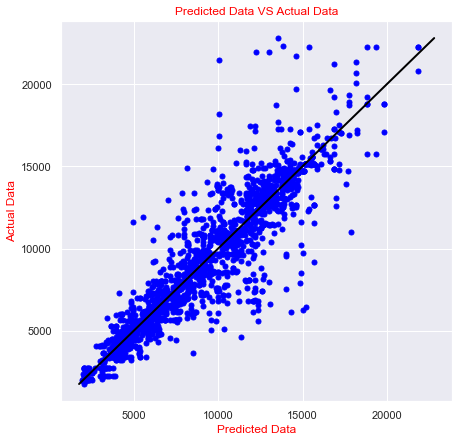

In [102]:
#Grid Search
params = [
    {'criterion':['mse'],'max_depth':list(range(5,20)),'min_samples_split':list(range(2,15)),"min_samples_leaf":[2,3,4]}
         ]
grid_search = GridSearchCV(estimator=DecisionTreeRegressor(),param_grid=params,cv=10,n_jobs=-1)

#Fitting the model
grid_search.fit(x_train,y_train)

#The best estimator
print('Best Estimator:',grid_search.best_estimator_)

#The best parameters
print('Best Params:',grid_search.best_params_)

#The predicted data
grid_pred = grid_search.predict(x_test)

#Decision tree performance after tuning
performance(grid_search,x_train,y_train,grid_pred,y_test)

#Plotting the results
plt.scatter(grid_pred,y_test,c='blue',marker='o',s=25)
plt.plot([y_test.min(),y_test.max()],[y_test.min(),y_test.max()],c='black',lw=2)
plt.xlabel('Predicted Data',c='red')
plt.ylabel('Actual Data',c='red')
plt.title('Predicted Data VS Actual Data',c='red')
plt.show()

- Amazing, the decision tree performance optimized and there are no overfitting.

#### Random Forest

Best Estimator: RandomForestRegressor(max_depth=15, min_samples_leaf=2, min_samples_split=9,
                      n_estimators=300)
Best Params: {'n_estimators': 300, 'min_samples_split': 9, 'min_samples_leaf': 2, 'max_depth': 15, 'criterion': 'mse'}
Training Score: 0.932590814647034
Testing Score: 0.8852238615292134
Other Metrics In Testing Data: 
MSE: 1879509.7711091666
MAE: 819.9366461937459


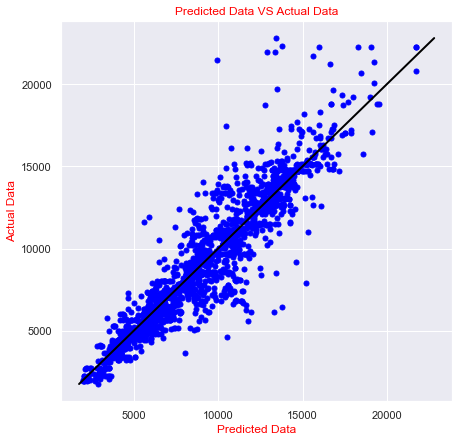

In [107]:
#Randomized search
params = [
    {'criterion':['mse'],'n_estimators':[100,200,300,400,500,600],
     'max_depth':list(range(5,20)),'min_samples_split':list(range(2,15)),"min_samples_leaf":[2,3,4,5]
     }
         ]
rand_search = RandomizedSearchCV(RandomForestRegressor(),params,cv=10,n_jobs=-1)

#Fitting the model
rand_search.fit(x_train,y_train)

#The best estimator
print('Best Estimator:',rand_search.best_estimator_)

#The best parameters
print('Best Params:',rand_search.best_params_)

#The predicted data
rand_pred = rand_search.predict(x_test)

#Decision tree performance after tuning
performance(rand_search,x_train,y_train,rand_pred,y_test)

#Plotting the results
plt.scatter(rand_pred,y_test,c='blue',marker='o',s=25)
plt.plot([y_test.min(),y_test.max()],[y_test.min(),y_test.max()],c='black',lw=2)
plt.xlabel('Predicted Data',c='red')
plt.ylabel('Actual Data',c='red')
plt.title('Predicted Data VS Actual Data',c='red')
plt.show()

- It's not a high performance after tuning but it's good.

#### XGB

Best Estimator: XGBRegressor(base_score=0.5, booster='gbtree', callbacks=None,
             colsample_bylevel=1, colsample_bynode=1, colsample_bytree=1,
             early_stopping_rounds=None, enable_categorical=False,
             eval_metric=None, gamma=0, gpu_id=-1, grow_policy='depthwise',
             importance_type=None, interaction_constraints='',
             learning_rate=0.1, max_bin=256, max_cat_to_onehot=4,
             max_delta_step=0, max_depth=7, max_leaves=0, min_child_weight=1,
             missing=nan, monotone_constraints='()', n_estimators=400, n_jobs=0,
             num_parallel_tree=1, predictor='auto', random_state=0, reg_alpha=0,
             reg_lambda=1, ...)
Best Params: {'n_estimators': 400, 'max_depth': 7, 'learning_rate': 0.1}
Training Score: 0.9624451628541499
Testing Score: 0.9008258613695005
Other Metrics In Testing Data: 
MSE: 1624020.158552398
MAE: 760.2815513142558


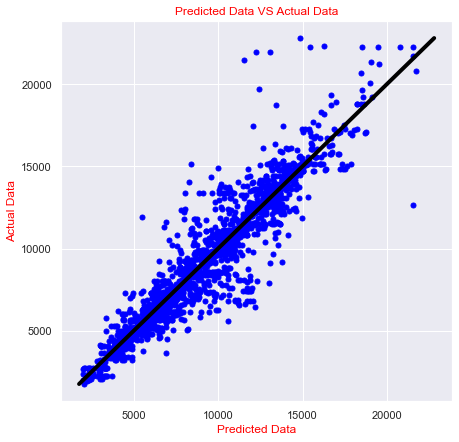

In [109]:
#Randomized search
params = {
         'max_depth': list(range(5,15)),'n_estimators': [300,400,500,600,700],'learning_rate': [0.01,0.1,0.2,0.9]
         }
rand_search = RandomizedSearchCV(XGBRegressor(),params,cv=10,n_jobs=-1)

#Fitting the model
rand_search.fit(x_train,y_train)

#The best estimator
print('Best Estimator:',rand_search.best_estimator_)

#The best parameters
print('Best Params:',rand_search.best_params_)

#The predicted data
rand_pred = rand_search.predict(x_test)

#Decision tree performance after tuning
performance(rand_search,x_train,y_train,rand_pred,y_test)

#Plotting the results
plt.scatter(rand_pred,y_test,c='blue',marker='o',s=25)
plt.plot([y_test.min(),y_test.max()],[y_test.min(),y_test.max()],c='black',lw=4)
plt.xlabel('Predicted Data',c='red')
plt.ylabel('Actual Data',c='red')
plt.title('Predicted Data VS Actual Data',c='red')
plt.show()

- `Xgboost` model is the best one.

### `Pipeline`

In [399]:
#Categorical and numerical data
cat_data = ['Airline','Source','Destination','Total_Stops','Additional_Info','WeekDay','Season']
num_data = ['Duration','Month','Day','Weekend']

#Splitting the data to x and y
x = df_new.drop(['Date_of_Journey','Route','Dep_Time', 'Arrival_Time','Price'],axis = 1)
y = df_new['Price']

#Columns transformer
column_trans = ColumnTransformer(
            [
            ('cat',OneHotEncoder(sparse=False), cat_data),
            ('num',StandardScaler(),num_data)
            ]
                                )
X_new = column_trans.fit_transform(x)

#Splitting the data for training and testing
X_train,X_test,Y_train,Y_test = train_test_split(X_new,y,test_size=0.2,random_state=0,shuffle=False)

#Applying pipeline
pipeline = make_pipeline(XGBRegressor(n_estimators=400,max_depth=7,learning_rate= 0.1))
pipeline.fit(X_train,Y_train)

#Pipeline score
print('Training Pipeline Score:',pipeline.score(X_train,Y_train))
print('Testing Pipeline Score:',pipeline.score(X_test,Y_test))

Training Pipeline Score: 0.9651173077918732
Testing Pipeline Score: 0.9025662642797289


### `Testing Stage`

In [425]:
#Reading the data
test_data = pd.read_excel('Test_set.xlsx')

#The first five rows
test_data.head()

,Airline,Date_of_Journey,Source,Destination,Route,Dep_Time,Arrival_Time,Duration,Total_Stops,Additional_Info
0,Jet Airways,6/06/2019,Delhi,Cochin,DEL → BOM → COK,17:30,04:25 07 Jun,10h 55m,1 stop,No info
1,IndiGo,12/05/2019,Kolkata,Banglore,CCU → MAA → BLR,06:20,10:20,4h,1 stop,No info
2,Jet Airways,21/05/2019,Delhi,Cochin,DEL → BOM → COK,19:15,19:00 22 May,23h 45m,1 stop,In-flight meal not included
3,Multiple carriers,21/05/2019,Delhi,Cochin,DEL → BOM → COK,08:00,21:00,13h,1 stop,No info
4,Air Asia,24/06/2019,Banglore,Delhi,BLR → DEL,23:55,02:45 25 Jun,2h 50m,non-stop,No info


In [426]:
test_data.isna().sum()

Airline            0
Date_of_Journey    0
Source             0
Destination        0
Route              0
Dep_Time           0
Arrival_Time       0
Duration           0
Total_Stops        0
Additional_Info    0
dtype: int64

- No missing values in the data.

In [427]:
#Preprocessing the data

#Taking a copy
new_test_data = test_data.copy()

#Converting the date from object type to datetime type
new_test_data['Date_of_Journey'] = pd.to_datetime(new_test_data['Date_of_Journey'],format='%d/%m/%Y')

#Appending month, day and weekday to the dataset
new_test_data['Month'] = new_test_data['Date_of_Journey'].dt.month
new_test_data['WeekDay'] = new_test_data['Date_of_Journey'].dt.day_name()
new_test_data['Day'] = new_test_data['Date_of_Journey'].dt.day

#Adding seasons feature
new_test_data['Season'] = new_test_data['Month'].apply(lambda month: check_season(month))

#Appending weekend column
new_test_data['Weekend'] = new_test_data['WeekDay'].apply(lambda day: 1 if day == 'Sunday' else 0)

#Converting the duration to seconds
new_test_data['Duration'] = new_test_data['Duration'].apply(lambda dur:convert_dur(dur))

#Removing some features
new_test_data = new_test_data.drop(['Date_of_Journey','Route','Dep_Time', 'Arrival_Time'],axis = 1)

In [428]:
new_test_data.head()

,Airline,Source,Destination,Duration,Total_Stops,Additional_Info,Month,WeekDay,Day,Season,Weekend
0,Jet Airways,Delhi,Cochin,39300,1 stop,No info,6,Thursday,6,Summer,0
1,IndiGo,Kolkata,Banglore,14400,1 stop,No info,5,Sunday,12,Summer,1
2,Jet Airways,Delhi,Cochin,85500,1 stop,In-flight meal not included,5,Tuesday,21,Summer,0
3,Multiple carriers,Delhi,Cochin,46800,1 stop,No info,5,Tuesday,21,Summer,0
4,Air Asia,Banglore,Delhi,10200,non-stop,No info,6,Monday,24,Summer,0


In [429]:
#Pipeline and the predicted values
X_test = column_trans.fit_transform(new_test_data)
pred = pipeline.predict(X_test)

In [434]:
#Appending the predicted values to the data set
test_data['Price'] = pred

#Appending the predicted values to the excel file
test_data.to_excel('Test_set.xlsx',index=False)